In [8]:
import uproot
import matplotlib.pyplot as plt 
import matplotlib as mpl
import mplhep as hep
import numpy as np
import fnmatch
from scipy.signal import find_peaks
import hist
from tqdm import tqdm
import pandas as pd
import os

In [60]:
idx_u0 = 0 
idx_v0 = 1984
idx_w0 = 3968
idx_u1 = 5632
idx_v1 = 7616
idx_w1 = 9600

def find_u0_ch(ch_num):
    if (((ch_num >= 0 ) & (ch_num < idx_v0))):
        return True
    else:
        return False

def find_v0_ch(ch_num):
    if (((ch_num >= idx_v0 ) & (ch_num < idx_w0))):
        return True
    else:
        return False
    
def find_w0_ch(ch_num):
    if (((ch_num >= idx_w0 ) & (ch_num < idx_u1))):
        return True
    else:
        return False
    
def find_u1_ch(ch_num):
    if (((ch_num >=  idx_u1 ) & (ch_num < idx_v1))):
        return True
    else:
        return False

def find_v1_ch(ch_num):
    if (((ch_num >= idx_v1 ) & (ch_num < idx_w1))):
        return True
    else:
        return False
    
def find_w1_ch(ch_num):
    if (((ch_num >= idx_w1 ))):
        return True
    else:
        return False

def u_ch(input): 
    tpc0_arr = input[0     :idx_v0]
    tpc1_arr = input[idx_u1:idx_v1]
    return np.concatenate([tpc0_arr,tpc1_arr])

def v_ch(input): 
    tpc0_arr = input[idx_v0:idx_w0]
    tpc1_arr = input[idx_v1:idx_w1]
    return np.concatenate([tpc0_arr,tpc1_arr])

def w_ch(input): 
    tpc0_arr = input[idx_w0:idx_u1]
    tpc1_arr = input[idx_w1:]
    return np.concatenate([tpc0_arr,tpc1_arr])

def u0_ch(input): 
    tpc0_arr = input[0     :idx_v0]
    return tpc0_arr

def v0_ch(input): 
    tpc0_arr = input[idx_v0:idx_w0]
    return tpc0_arr

def w0_ch(input): 
    tpc0_arr = input[idx_w0:idx_u1]
    return tpc0_arr

def u1_ch(input): 
    tpc1_arr = input[idx_u1:idx_v1]
    return tpc1_arr

def v1_ch(input): 
    tpc1_arr = input[idx_v1:idx_w1]
    return tpc1_arr

def w1_ch(input): 
    tpc1_arr = input[idx_w1:]
    return tpc1_arr

def quartile_reso(data):
    data = np.round(np.sort(data),3)
    median = np.ma.median(np.ma.array(data, mask=np.isnan(data)))
    median_idx = int(np.round(len(data)/2))
    quar_size =  int(np.round(len(data)*0.5*0.683))
    Q1 = data[median_idx - quar_size]
    Q3 = data[median_idx + quar_size]
    quartile_reso = np.sqrt(0.5*(median-Q1)**2 + 0.5*(median-Q3)**2)
    return quartile_reso

def find_nonzero_ch(wvfm):
    # peak threshold = 800
    mask = (wvfm > 800).sum(axis = 1)
    return np.where(mask>0)[0]

In [4]:
# with open("electron_caf.list") as f:
with open("electron_caf_edited.list") as f:
    caf_list = f.read().split('\n')

with open("electron_wvfm.list") as f:
    wvfm_list = f.read().split('\n')

In [5]:
def pass_dec(dec_arr):
    """
    Returns a np.array of deconvolved channels with either 800 e- peak height or average charge above 400 e-
    """
    dec_sum = np.sum(dec_arr,axis=1)
    dec_ch  = np.where(dec_sum>1)[0] # array of ch numbers, nonzero channels
    # list of channels with peak height above 800
    pass_peak = dec_ch[np.where(np.max(dec_arr[dec_ch],axis=1)>800)[0]]
    pass_avg  = []
    # if a channel has nonzero but peak height below 800:
    for ch in dec_ch[np.where(np.max(dec_arr[dec_ch],axis=1)<800)[0]]:
        dec_peak, dec_prop = find_peaks(dec_arr[ch],height=5,width=0)
        # in case there are multiple peaks in the waveform, take the one with the highest peak height
        if len(dec_peak) ==0: continue
        peak_idx = np.argmax(dec_prop["peak_heights"])
        dec_charge = dec_arr[ch][dec_prop["left_bases"][peak_idx]:dec_prop["right_bases"][peak_idx]].sum()
        dec_width  = dec_prop["right_bases"][peak_idx]-dec_prop["left_bases"][peak_idx]
        # calculate the average charge in the peak
        dec_avg = dec_charge / dec_width
        if dec_avg > 400: pass_avg.append(ch)
    pass_avg = np.array(pass_avg,dtype=int)
    dec_pass = np.concatenate([pass_peak,pass_avg])
    ch_bool = np.zeros(len(dec_arr),dtype=bool)
    ch_bool[dec_pass] = True
    return ch_bool

def pass_sim(sim_arr):
    """
    Returns a np.array of simulated channels with integrated charge (for the largest hit) above 2500
    """
    sim_ch = np.where(np.sum(sim_arr,axis=1)>=2500)[0]
    for ch in sim_ch:
        sim_peak, sim_prop = find_peaks(sim_arr[ch],height=5,width=0)
        peak_idx = np.argmax(sim_prop["peak_heights"])
        sim_charge = sim_arr[ch][sim_prop["left_bases"][peak_idx]:sim_prop["right_bases"][peak_idx]].sum()
        if sim_charge < 2500: sim_ch = np.delete(sim_ch,np.where(sim_ch==ch))
    ch_bool = np.zeros(len(sim_arr),dtype=bool)
    ch_bool[sim_ch] = True
    return ch_bool

In [9]:
for file_idx in tqdm(range(len(caf_list))):
# for idx in range(1):
    N = 20 # number of events
    file_arr =  np.zeros(shape=(N,2)); subrun_arr = np.zeros(shape=(N,2)); tpc_arr =    np.zeros(shape=(N,2))
    u_diff_arr =np.zeros(shape=(N,2)); v_diff_arr = np.zeros(shape=(N,2)); w_diff_arr = np.zeros(shape=(N,2))
    u_sim_arr = np.zeros(shape=(N,2)); v_sim_arr =  np.zeros(shape=(N,2)); w_sim_arr =  np.zeros(shape=(N,2))
    u_dec_arr = np.zeros(shape=(N,2)); v_dec_arr =  np.zeros(shape=(N,2)); w_dec_arr =  np.zeros(shape=(N,2)) 
    u_pur_arr = np.zeros(shape=(N,2)); v_pur_arr =  np.zeros(shape=(N,2)); w_pur_arr =  np.zeros(shape=(N,2))
    u_eff_arr = np.zeros(shape=(N,2)); v_eff_arr =  np.zeros(shape=(N,2)); w_eff_arr =  np.zeros(shape=(N,2))
    theta_arr = np.zeros(shape=(N,2)); depE_arr =   np.zeros(shape=(N,2))
    
    wvfm = uproot.open(wvfm_list[file_idx])
    dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
    sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
    raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

    caf = uproot.open(caf_list[file_idx]+":recTree")
    tree = caf.arrays(["rec.hdr.run","rec.hdr.subrun","rec.hdr.evt",
                    "rec.mc.nu.prim.startp.x" ,"rec.mc.nu.prim.startp.y","rec.mc.nu.prim.startp.z",
                    "rec.mc.nu.prim.startE","rec.mc.nu.prim.endE"],library='pd')

    tree["theta_xz"] = np.arctan(abs(tree["rec.mc.nu.prim.startp.x"]/tree["rec.mc.nu.prim.startp.z"]))*(180/np.pi)
    tree["depE"] =  tree["rec.mc.nu.prim.startE"] - tree["rec.mc.nu.prim.endE"]
    tree["tpc"] = np.where(tree["rec.mc.nu.prim.startp.x"]>0,1,0)
    subrun = tree.iloc[0]["rec.hdr.subrun"]

    for event in range(len(dec_names)):
        evt_sim = wvfm[sim_names[event]].values()
        evt_dec = wvfm[dec_names[event]].values()*50
        
        for tpc in range(2):
            this_tree = tree[tree.tpc==0] if tpc == 0 else tree[tree.tpc==1]
            u_sim = u0_ch(evt_sim) if tpc == 0 else u1_ch(evt_sim); u_dec = u0_ch(evt_dec) if tpc == 0 else u1_ch(evt_dec)
            v_sim = v0_ch(evt_sim) if tpc == 0 else v1_ch(evt_sim); v_dec = v0_ch(evt_dec) if tpc == 0 else v1_ch(evt_dec)
            w_sim = w0_ch(evt_sim) if tpc == 0 else w1_ch(evt_sim); w_dec = w0_ch(evt_dec) if tpc == 0 else w1_ch(evt_dec)
            
            u_sim_bool = pass_sim(u_sim); v_sim_bool = pass_sim(v_sim); w_sim_bool = pass_sim(w_sim)
            u_dec_bool = pass_dec(u_dec); v_dec_bool = pass_dec(v_dec); w_dec_bool = pass_dec(w_dec)
            
            u_sim_sum = np.sum(u_sim[u_sim_bool]); v_sim_sum = np.sum(v_sim[v_sim_bool]); w_sim_sum = np.sum(w_sim[w_sim_bool])
            u_dec_sum = np.sum(u_dec[u_dec_bool]); v_dec_sum = np.sum(v_dec[v_dec_bool]); w_dec_sum = np.sum(w_dec[w_dec_bool])
            
            u_noise = len(np.where((~u_sim_bool) & ( u_dec_bool))[0]); v_noise = len(np.where((~v_sim_bool) & ( v_dec_bool))[0]); w_noise = len(np.where((~w_sim_bool) & ( w_dec_bool))[0])
            u_fail  = len(np.where(( u_sim_bool) & (~u_dec_bool))[0]); v_fail  = len(np.where(( v_sim_bool) & (~v_dec_bool))[0]); w_fail  = len(np.where(( w_sim_bool) & (~w_dec_bool))[0])
            
            u_nsim = len(np.where(u_sim_bool)[0]); v_nsim = len(np.where(v_sim_bool)[0]); w_nsim = len(np.where(w_sim_bool)[0])
            u_ndec = len(np.where(u_dec_bool)[0]); v_ndec = len(np.where(v_dec_bool)[0]); w_ndec = len(np.where(w_dec_bool)[0])
            
            u_pur = (1-(u_noise/u_ndec))*100 if u_ndec!=0 else 0; v_pur = (1-(v_noise/v_ndec))*100 if v_ndec!=0 else 0; w_pur = (1-(w_noise/w_ndec))*100 if w_ndec!=0 else 0
            u_eff = (1-(u_fail/u_nsim))*100 if u_nsim!=0 else 0; v_eff = (1-(v_fail/v_nsim))*100 if v_nsim!=0 else 0; w_eff = (1-(w_fail/w_nsim))*100 if w_nsim!=0 else 0

            u_diff_arr[event][tpc] = (u_dec_sum - u_sim_sum)/u_dec_sum
            v_diff_arr[event][tpc] = (v_dec_sum - v_sim_sum)/v_dec_sum
            w_diff_arr[event][tpc] = (w_dec_sum - w_sim_sum)/w_dec_sum
            u_sim_arr[event][tpc] = u_sim_sum; v_sim_arr[event][tpc] = v_sim_sum; w_sim_arr[event][tpc] = w_sim_sum
            u_dec_arr[event][tpc] = u_dec_sum; v_dec_arr[event][tpc] = v_dec_sum; w_dec_arr[event][tpc] = w_dec_sum
            u_pur_arr[event][tpc]  = u_pur; v_pur_arr[event][tpc]  = v_pur; w_pur_arr[event][tpc]  = w_pur
            u_eff_arr[event][tpc]  = u_eff; v_eff_arr[event][tpc]  = v_eff; w_eff_arr[event][tpc]  = w_eff
            theta_arr[event][tpc]  = this_tree.iloc[event]["theta_xz"]
            depE_arr[event][tpc]   = this_tree.iloc[event]["depE"]
            tpc_arr[event][tpc]    = tpc
            file_arr[event][tpc]   = file_idx
            subrun_arr[event][tpc] = subrun

    df0 = pd.DataFrame({'file' : file_arr[:,0], 'sub' : subrun_arr[:,0], 'tpc' : tpc_arr[:,0],'u': u_diff_arr[:,0], 'v': v_diff_arr[:,0], 'w': w_diff_arr[:,0],
                        'u_pur' : u_pur_arr[:,0], 'v_pur' : v_pur_arr[:,0], 'w_pur' : w_pur_arr[:,0],
                        'u_eff' : u_eff_arr[:,0], 'v_eff' : v_eff_arr[:,0], 'w_eff' : w_eff_arr[:,0],
                        'u_sim' : u_sim_arr[:,0], 'v_sim' : v_sim_arr[:,0], 'w_sim' : w_sim_arr[:,0],
                        'u_dec' : u_dec_arr[:,0], 'v_dec' : v_dec_arr[:,0], 'w_dec' : w_dec_arr[:,0],
                        "theta_xz" : theta_arr[:,0], 'depE' : depE_arr[:,0]})
    df1 = pd.DataFrame({'file' : file_arr[:,1], 'sub' : subrun_arr[:,1], 'tpc' : tpc_arr[:,1],'u': u_diff_arr[:,1], 'v': v_diff_arr[:,1], 'w': w_diff_arr[:,1],
                        'u_pur' : u_pur_arr[:,1], 'v_pur' : v_pur_arr[:,1], 'w_pur' : w_pur_arr[:,1],
                        'u_eff' : u_eff_arr[:,1], 'v_eff' : v_eff_arr[:,1], 'w_eff' : w_eff_arr[:,1],
                        'u_sim' : u_sim_arr[:,1], 'v_sim' : v_sim_arr[:,1], 'w_sim' : w_sim_arr[:,1],
                        'u_dec' : u_dec_arr[:,1], 'v_dec' : v_dec_arr[:,1], 'w_dec' : w_dec_arr[:,1],
                        "theta_xz" : theta_arr[:,1], 'depE' : depE_arr[:,1]})
    df = pd.concat([df0,df1])
    df.to_pickle("pkl_files/subrun_"+str(int(subrun))+".pkl")  

 58%|█████▊    | 137/236 [1:09:19<49:34, 30.04s/it]/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in multiply
/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in float_scalars
 61%|██████▏   | 145/236 [1:13:22<45:56, 30.29s/it]/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in float_scalars
/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in float_scalars
 69%|██████▉   | 164/236 [1:22:58<35:49, 29.85s/it]/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in float_scalars
/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in float_scalars

FileNotFoundError: file not found

    ''

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


## Validation

In [10]:
list_of_df = []
# iterate over files in directory
for filename in os.listdir("./pkl_files/"):
    list_of_df.append(pd.read_pickle("./pkl_files/" +filename))
df = pd.concat(list_of_df)
df

,file,sub,tpc,u,v,w,u_pur,v_pur,w_pur,u_eff,v_eff,w_eff,u_sim,v_sim,w_sim,u_dec,v_dec,w_dec,theta_xz,depE
0,130.0,9.0,0.0,-0.125261,-0.106314,-0.013191,98.275862,79.090909,100.0,95.000000,90.625000,97.159091,9.623076e+06,9.624342e+06,9.634530e+06,8551860.0,8699465.0,9509095.0,42.514923,0.414485
1,130.0,9.0,0.0,-0.337987,-0.299009,-0.019824,100.000000,88.489209,100.0,88.961039,87.857143,95.061728,2.698251e+07,2.699536e+07,2.703247e+07,20166494.0,20781508.0,26507000.0,50.507675,1.134491
2,130.0,9.0,0.0,-0.093690,-0.070728,-0.029897,100.000000,79.761905,100.0,93.333333,87.012987,91.275168,5.460179e+06,5.443354e+06,5.470167e+06,4992439.0,5083788.0,5311372.0,54.215088,0.218801
3,130.0,9.0,0.0,-0.235973,-0.067662,-0.010469,96.875000,65.116279,100.0,81.578947,82.352941,87.500000,3.613205e+06,3.618521e+06,3.615334e+06,2923368.0,3389202.0,3577876.0,78.434502,0.140922
4,130.0,9.0,0.0,-0.117029,-0.050394,-0.025333,100.000000,83.529412,100.0,88.461538,92.207792,90.000000,4.806270e+06,4.811760e+06,4.797415e+06,4302727.0,4580912.0,4678887.0,34.257397,0.186508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,227.0,183.0,1.0,-0.307122,-0.370806,-0.007276,96.153846,44.444444,100.0,86.206897,82.758621,89.189189,4.304067e+06,4.306547e+06,4.309622e+06,3292781.0,3141617.0,4278490.0,82.525436,0.321116
16,227.0,183.0,1.0,-0.192714,-0.145382,-0.030693,100.000000,94.210526,100.0,91.304348,91.326531,93.820225,1.818962e+07,1.819517e+07,1.818717e+07,15250615.0,15885671.0,17645572.0,17.951300,0.721694
17,227.0,183.0,1.0,-0.058612,0.443460,0.006321,100.000000,16.000000,100.0,80.000000,57.142857,100.000000,2.034186e+05,2.051154e+05,2.021560e+05,192156.0,368555.0,203442.0,71.058136,0.008155
18,227.0,183.0,1.0,-0.066955,-0.066414,-0.024827,100.000000,88.983051,100.0,96.621622,85.365854,92.021277,9.017903e+06,9.011898e+06,8.987710e+06,8452002.0,8450654.0,8769976.0,44.195198,0.355094


In [11]:
u_diff_arr = df["u"].to_numpy()
v_diff_arr = df["v"].to_numpy()
w_diff_arr = df["w"].to_numpy()

u_sim_arr = df["u_sim"].to_numpy()
v_sim_arr = df["v_sim"].to_numpy()
w_sim_arr = df["w_sim"].to_numpy()

u_dec_arr = df["u_dec"].to_numpy()
v_dec_arr = df["v_dec"].to_numpy()
w_dec_arr = df["w_dec"].to_numpy()

u_pur_arr = df["u_pur"].to_numpy()
v_pur_arr = df["v_pur"].to_numpy()
w_pur_arr = df["w_pur"].to_numpy()

u_eff_arr = df["u_eff"].to_numpy()
v_eff_arr = df["v_eff"].to_numpy()
w_eff_arr = df["w_eff"].to_numpy()

theta_xz_arr = df["theta_xz"].to_numpy()
depE_arr = df["depE"].to_numpy()

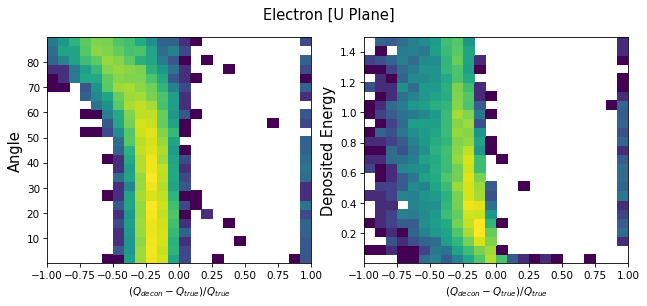

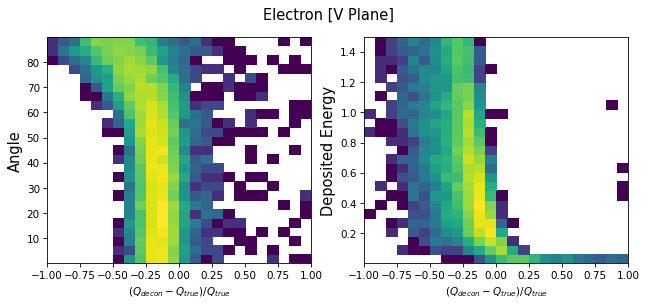

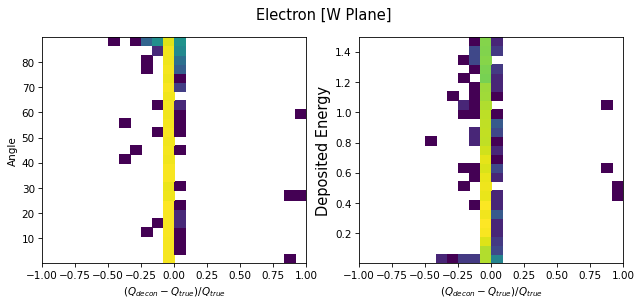

In [12]:
fig, axes = plt.subplots(1,2,figsize=(10,4),dpi=75)
axes[0].hist2d(u_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[1].hist2d(u_diff_arr,depE_arr,    bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[0].set_ylabel("Angle",fontsize=14)
axes[1].set_ylabel("Deposited Energy",fontsize=14)
axes[0].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
axes[1].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")

plt.suptitle("Electron [U Plane]",fontsize=14)
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,4),dpi=75)
axes[0].hist2d(v_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[1].hist2d(v_diff_arr,depE_arr,    bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[0].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
axes[1].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")

axes[0].set_ylabel("Angle",fontsize=14)
axes[1].set_ylabel("Deposited Energy",fontsize=14)
plt.suptitle("Electron [V Plane]",fontsize=14)
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,4),dpi=75)
axes[0].hist2d(w_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[1].hist2d(w_diff_arr,depE_arr,    bins=[np.linspace(-1,1,25),25],norm=mpl.colors.LogNorm())
axes[0].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
axes[1].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")

axes[0].set_ylabel("Angle")
axes[1].set_ylabel("Deposited Energy",fontsize=14)
plt.suptitle("Electron [W Plane]",fontsize=14)
plt.show()

In [18]:
ticks= [0,5,10,20,30,40,50,60,70,80,85]
ticks_prime = np.zeros(len(ticks))
for i, tick in enumerate(ticks):
    ticks_prime[i] = np.round(np.arctan(np.tan(tick*np.pi/180)/np.cos(60*np.pi/180))*180/np.pi)
    
ticklabels = []
for i, angle in enumerate(ticks):
    ticklabels.append(str(int(angle)) + "(" + str(int(ticks_prime[i])) + ")")

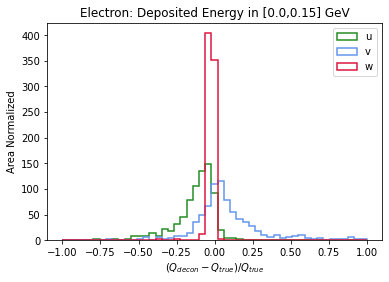

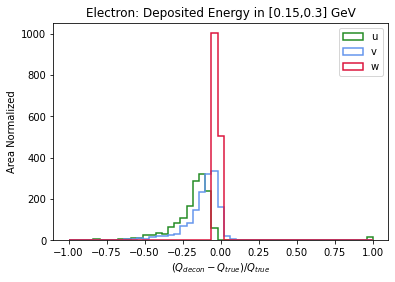

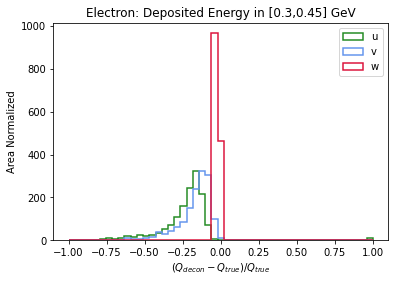

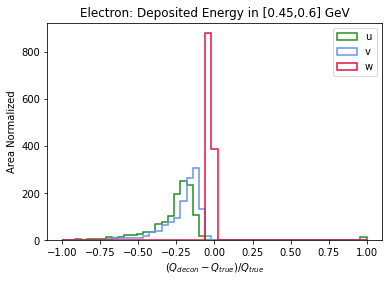

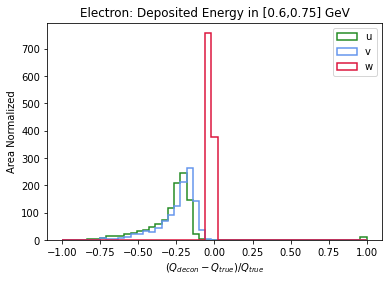

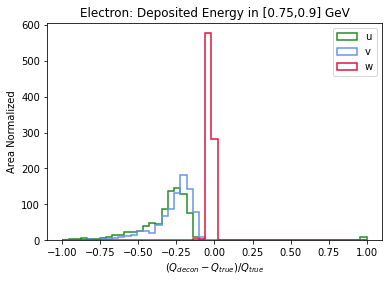

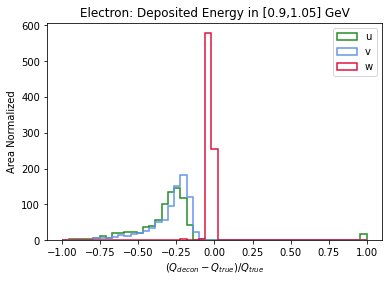

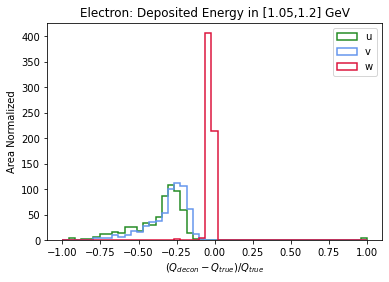

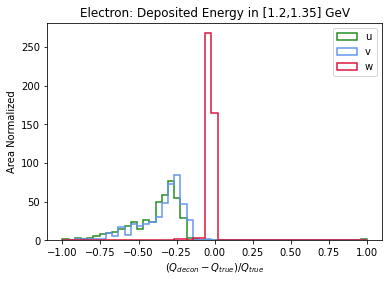

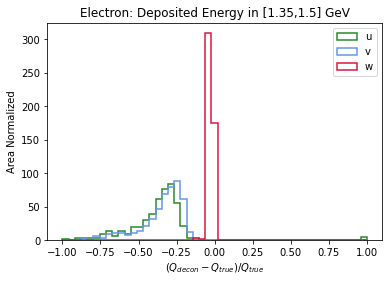

In [68]:
u_med_eng = np.zeros(10); u_std_eng = np.zeros(10); u_eff_eng = np.zeros(10) ; u_pur_eng = np.zeros(10)
v_med_eng = np.zeros(10); v_std_eng = np.zeros(10); v_eff_eng = np.zeros(10) ; v_pur_eng = np.zeros(10)
w_med_eng = np.zeros(10); w_std_eng = np.zeros(10); w_eff_eng = np.zeros(10) ; w_pur_eng = np.zeros(10)

energy_bins = np.linspace(0,1.5,11)
for i in range(len(energy_bins)-1):
    lower = energy_bins[i]
    upper = energy_bins[i+1]
    mask = np.where((depE_arr < upper) & (depE_arr >= lower),True,False)  
    u_med_eng[i] = np.ma.median(np.ma.array(u_diff_arr[mask], mask=np.isnan(u_diff_arr[mask]))) #& (u_fail == False)])
    u_std_eng[i] = quartile_reso(np.ma.array(u_diff_arr[mask], mask=np.isnan(u_diff_arr[mask]))) #& (u_fail == False)])
    v_med_eng[i] = np.median(v_diff_arr[(mask) ]) #& (v_fail == False)])
    v_std_eng[i] = quartile_reso(v_diff_arr[(mask) ]) #& (v_fail == False)])
    w_med_eng[i] = np.ma.median(np.ma.array(w_diff_arr[mask], mask=np.isnan(w_diff_arr[mask]))) #& (w_fail == False)])
    w_std_eng[i] = quartile_reso(np.ma.array(w_diff_arr[mask], mask=np.isnan(w_diff_arr[mask]))) #& (w_fail == False)])
    u_eff_eng[i] = np.median(1- 0.01*u_eff_arr[mask])
    v_eff_eng[i] = np.median(1- 0.01*v_eff_arr[mask])
    w_eff_eng[i] = np.median(1- 0.01*w_eff_arr[mask])
    u_pur_eng[i] = np.median(1-0.01*u_pur_arr[(mask) & (u_pur_arr != 0)])
    v_pur_eng[i] = np.median(1-0.01*v_pur_arr[(mask) & (u_pur_arr != 0)])
    w_pur_eng[i] = np.median(1-0.01*w_pur_arr[(mask) & (u_pur_arr != 0)])
    plt.hist(u_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="u",color="forestgreen")
    plt.hist(v_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="v",color="cornflowerblue")
    plt.hist(w_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="w",color="crimson")
    plt.legend()
    plt.ylabel("Area Normalized")
    plt.xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
    plt.title(fr"Electron: Deposited Energy in [{round(lower,3)},{round(upper,3)}] GeV")
    # plt.yscale("log")
    plt.show()
    

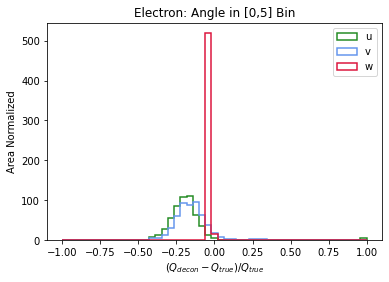

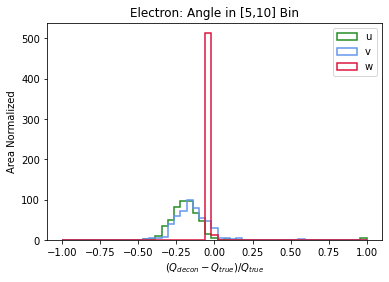

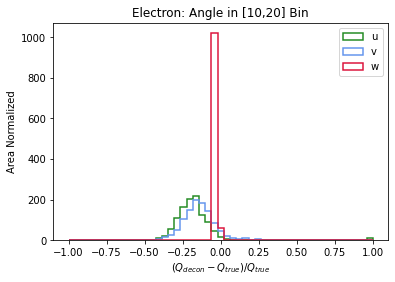

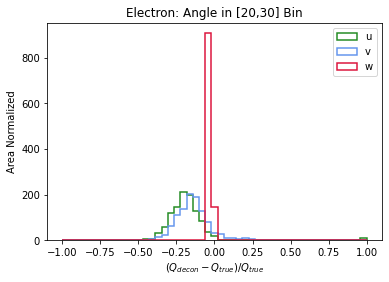

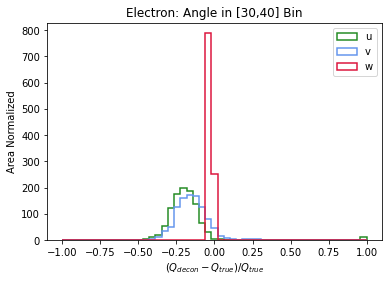

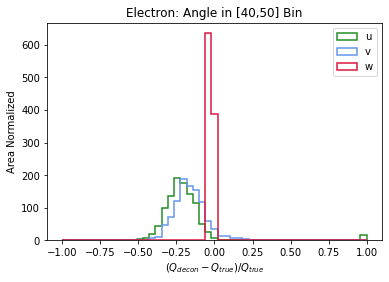

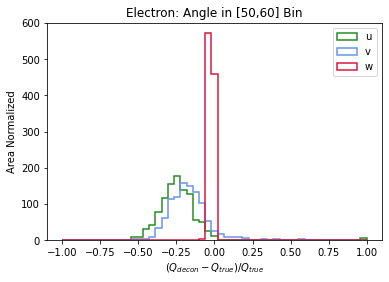

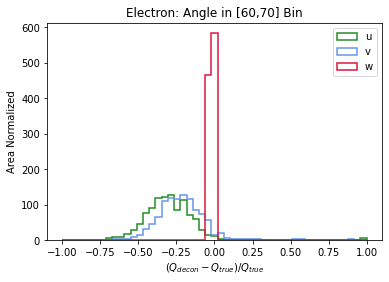

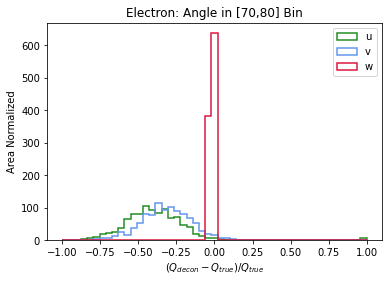

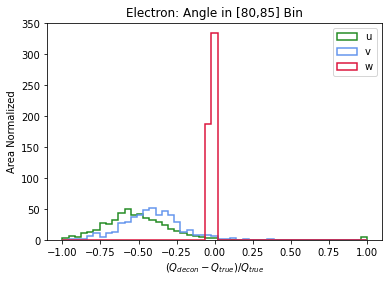

In [41]:
u_med_ang = np.zeros(10); u_std_ang = np.zeros(10); u_eff_ang = np.zeros(10) ; u_pur_ang = np.zeros(10)
v_med_ang = np.zeros(10); v_std_ang = np.zeros(10); v_eff_ang = np.zeros(10) ; v_pur_ang = np.zeros(10)
w_med_ang = np.zeros(10); w_std_ang = np.zeros(10); w_eff_ang = np.zeros(10) ; w_pur_ang = np.zeros(10)

for i in range(len(ticks)-1):
    lower = ticks[i]
    upper = ticks[i+1]
    mask = np.where((theta_xz_arr < upper) & (theta_xz_arr >= lower),True,False)  
    u_med_ang[i] = np.median(u_diff_arr[(mask) ]) #& (u_fail == False)])
    u_std_ang[i] = quartile_reso(u_diff_arr[(mask) ]) #& (u_fail == False)])
    v_med_ang[i] = np.median(v_diff_arr[(mask) ]) #& (v_fail == False)])
    v_std_ang[i] = quartile_reso(v_diff_arr[(mask) ]) #& (v_fail == False)])
    w_med_ang[i] = np.median(w_diff_arr[(mask) ]) #& (w_fail == False)])
    w_std_ang[i] = quartile_reso(w_diff_arr[(mask) ]) #& (w_fail == False)])
    u_eff_ang[i] = np.mean(1- 0.01*u_eff_arr[mask])
    v_eff_ang[i] = np.mean(1- 0.01*v_eff_arr[mask])
    w_eff_ang[i] = np.mean(1- 0.01*w_eff_arr[mask])
    u_pur_ang[i] = np.mean(1-0.01*u_pur_arr[mask])
    v_pur_ang[i] = np.mean(1-0.01*v_pur_arr[mask])
    w_pur_ang[i] = np.mean(1-0.01*w_pur_arr[mask])
    plt.hist(u_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="u",color="forestgreen")
    plt.hist(v_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="v",color="cornflowerblue")
    plt.hist(w_diff_arr[mask],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="w",color="crimson")
    plt.legend()
    plt.ylabel("Area Normalized")
    plt.xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
    plt.title(fr"Electron: Angle in [{lower},{upper}] Bin")
    # plt.yscale("log")
    plt.show()
    

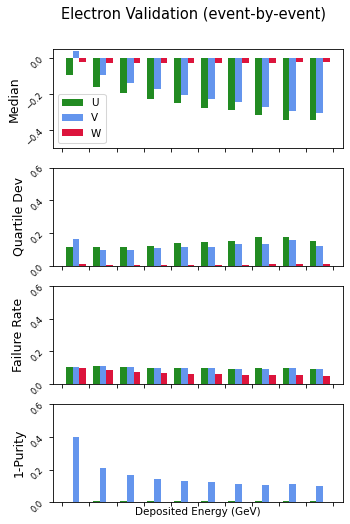

In [69]:
fig, axes = plt.subplots(4,1,figsize=(5,8),sharex=True,dpi=75)
# plt.subplots_adjust(hspace=0.08)
N=10
width = 0.25
# ticklabels = ["0","5","10","20","30","40","50","60","70","80","85"]
axes[0].set_xticks(np.arange(N+1)-0.5)
axes[0].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[0].bar(np.arange(N)-width, u_med_eng,width=width,label="U",color="forestgreen")
axes[0].bar(np.arange(N)      , v_med_eng,width=width,label="V",color="cornflowerblue")
axes[0].bar(np.arange(N)+width, w_med_eng,width=width,label="W",color="crimson")
axes[0].set_ylabel("Median",fontsize=12)
axes[0].legend()
axes[0].set_ylim(-0.50,0.05)

axes[1].bar(np.arange(N)-width,u_std_eng,width=width,label="U",color="forestgreen")
axes[1].bar(np.arange(N),      v_std_eng,width=width,label="V",color="cornflowerblue")
axes[1].bar(np.arange(N)+width,w_std_eng,width=width,label="W",color="crimson")
axes[1].set_ylabel("Quartile Dev",fontsize=12)
axes[1].tick_params(labelbottom=False)
axes[1].set_yticks([0.0,0.2,0.4,0.6])
axes[1].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[1].set_ylim(0,0.6)

axes[2].bar(np.arange(N)-width,u_eff_eng,width=width,label="U",color="forestgreen")
axes[2].bar(np.arange(N),      v_eff_eng,width=width,label="V",color="cornflowerblue")
axes[2].bar(np.arange(N)+width,w_eff_eng,width=width,label="W",color="crimson")
axes[2].set_ylabel("Failure Rate",fontsize=12)
axes[2].tick_params(labelbottom=False)
axes[2].set_yticks([0.0,0.2,0.4,0.6])
axes[2].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[2].set_ylim(0,0.6)

axes[3].bar(np.arange(N)-width,u_pur_eng,width=width,label="U",color="forestgreen")
axes[3].bar(np.arange(N),      v_pur_eng,width=width,label="V",color="cornflowerblue")
axes[3].bar(np.arange(N)+width,w_pur_eng,width=width,label="W",color="crimson")
axes[3].set_ylabel("1-Purity",fontsize=12)
axes[3].tick_params(labelbottom=False)
axes[3].set_yticks([0.0,0.2,0.4,0.6])
axes[3].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[3].set_ylim(0,0.6)
axes[3].set_xticklabels(englabels)
axes[3].xaxis.set_tick_params(labelsize=8,rotation=45)
axes[3].set_xlabel("Deposited Energy (GeV)")


plt.suptitle("Electron Validation (event-by-event)",fontsize=14,y=0.95)
plt.show()

## Waveforms

In [43]:
idx = 5
evtnum = idx//2
tpcnum = abs(idx%2 - 1) # actually the tpc order is flipped due to the order of tpc0 and tpc1 in the cafs
sim_arr = wvfm[sim_names[evtnum]].values()[:idx_u1,:] if tpcnum == 0 else wvfm[sim_names[evtnum]].values()[idx_u1:,:]
dec_arr = wvfm[dec_names[evtnum]].values()[:idx_u1,:]*50 if tpcnum == 0 else wvfm[dec_names[evtnum]].values()[idx_u1:,:]*50
raw_arr = wvfm[raw_names[evtnum]].values()[:idx_u1,:] if tpcnum == 0 else wvfm[raw_names[evtnum]].values()[idx_u1:,:]
nonzeroch = find_nonzero_ch(sim_arr)
print("sim sum for event", np.sum(sim_arr))
print("dec sum for event", np.sum(dec_arr))

sim_sum = np.sum(sim_arr[nonzeroch],axis=1)     # array of sim sum of each channel
dec_sum = np.sum(dec_arr[nonzeroch],axis=1)  # array of dec sum of each channel
over_mask = np.where((dec_sum - sim_sum)/sim_sum > 0,True,False)         # mask of channels that are over
over_arr = nonzeroch[np.where((dec_sum - sim_sum)/sim_sum > 0,True,False)]

sim sum for event 57723732.0
dec sum for event 46125216.0


In [44]:
def plot_wvfms(chnum:int, range: list = [0,2500], textxcoord: float = 0.5):
    """
    Plots waveform of the specified channel number, as well as the neighborhoring two channels
    """
    fig, axes = plt.subplots(3,1,figsize=(10,10))
    for i, shift in enumerate([-1,0,1]):
        hep.histplot(wvfm[sim_names[evtnum]].values()[chnum+shift]   ,ax=axes[i], label="sim")
        hep.histplot(wvfm[raw_names[evtnum]].values()[chnum+shift]*20,ax=axes[i], label="raw [x20]")
        hep.histplot(wvfm[dec_names[evtnum]].values()[chnum+shift]*50,ax=axes[i], label="dec")
        axes[i].set_title("Channel "+str(chnum+shift))
        axes[i].set_xlim(range)
        axes[i].legend()
        sim_ch_sum = np.sum(wvfm[sim_names[evtnum]].values()[chnum+shift][range[0]:range[1]])
        dec_ch_sum = np.sum(wvfm[dec_names[evtnum]].values()[chnum+shift][range[0]:range[1]]*50)
        diff_ch = (dec_ch_sum - sim_ch_sum)/sim_ch_sum
        axes[i].annotate(f"sim integral: {sim_ch_sum:.0f}",     (textxcoord,0.8) ,xycoords='axes fraction',fontsize=12)
        axes[i].annotate(f"dec integral: {dec_ch_sum:.0f}",     (textxcoord,0.7),xycoords='axes fraction',fontsize=12)
        axes[i].annotate(f"fractional diff: {diff_ch*100:.1f}%",(textxcoord,0.6),xycoords='axes fraction',fontsize=12)
    plt.show()

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in float_scalars
  from ipykernel import kernelapp as app


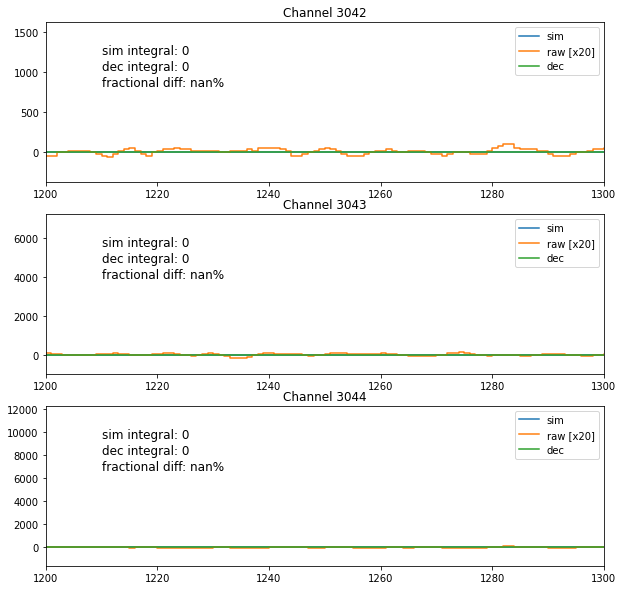

In [45]:
chidx = 15
plot_wvfms(over_arr[chidx]
           ,range=[1200,1300]
           ,textxcoord=0.1)

## Quantifying ROI failure 

- compare the difference between the start of the decon ROI and sim signal start and the end of decon ROI and sim signal end across sim integral channels 
- also quantify the distribution of low Q_sim and high Q_sim for different energy bins of electron energy 

In [46]:
df.iloc[3].tpc

0.0

In [47]:
peak_counter = 0
peaks_counter = 0
zero_counter = 0

left_diff = []
right_diff = []
sim_width = []
dec_width = []
sim_charge = []
dec_charge = []
charge_diff = []
plane = [] # 0 for u, 1 for v, 2 for w

for idx in range(0,40): # event loop 
    tpcnum = df.iloc[idx].tpc
    evtnum = idx//2
    sim_arr = wvfm[sim_names[evtnum]].values()[:idx_u1,:] if tpcnum == 0 else wvfm[sim_names[evtnum]].values()[idx_u1:,:]
    dec_arr = wvfm[dec_names[evtnum]].values()[:idx_u1,:]*50 if tpcnum == 0 else wvfm[dec_names[evtnum]].values()[idx_u1:,:]*50
    raw_arr = wvfm[raw_names[evtnum]].values()[:idx_u1,:] if tpcnum == 0 else wvfm[raw_names[evtnum]].values()[idx_u1:,:]
    nonzeroch = find_nonzero_ch(sim_arr)
    sim_sum = np.sum(sim_arr[nonzeroch],axis=1)     # array of sim sum of each channel
    dec_sum = np.sum(dec_arr[nonzeroch],axis=1)  # array of dec sum of each channel
    over_arr = nonzeroch[np.where((dec_sum - sim_sum)/sim_sum > 0,True,False)]
    for ch in nonzeroch:
        sim_peaks, sim_prop = find_peaks(sim_arr[ch],height=800,distance=1000,prominence=0)
        dec_peaks, dec_prop = find_peaks(dec_arr[ch],height=800,distance=1000,prominence=0)
        if (len(sim_peaks) == len(dec_peaks)):
            peak_counter += 1
            for peak_idx in range(len(sim_peaks)):
                if abs(sim_peaks[peak_idx] - dec_peaks[peak_idx]) < 100:
                    left_diff.append(sim_prop['left_bases'][peak_idx] - dec_prop['left_bases'][peak_idx])
                    right_diff.append(sim_prop['right_bases'][peak_idx] - dec_prop['right_bases'][peak_idx])
                    sim_width.append(sim_prop['right_bases'][peak_idx] - sim_prop["left_bases"][peak_idx])
                    dec_width.append(dec_prop['right_bases'][peak_idx] - dec_prop["left_bases"][peak_idx])
                    sim_peak_sum = np.sum(sim_arr[ch][sim_prop['left_bases'][peak_idx]:sim_prop['right_bases'][peak_idx]])
                    dec_peak_sum = np.sum(dec_arr[ch][dec_prop['left_bases'][peak_idx]:dec_prop['right_bases'][peak_idx]])
                    sim_charge.append(sim_peak_sum)
                    dec_charge.append(dec_peak_sum)
                    charge_diff.append((dec_peak_sum - sim_peak_sum)/sim_peak_sum)
                    if (find_u0_ch(ch)):
                        plane.append(0)
                    elif (find_v0_ch(ch)):
                        plane.append(1)
                    elif (find_w0_ch(ch)):
                        plane.append(2)
        elif (len(sim_peaks) != len(dec_peaks)):
            peaks_counter += 1
    print("peak_counter",peak_counter)
    print("peaks_counter",peaks_counter)

left_diff = np.array(left_diff); right_diff = np.array(right_diff); charge_diff = np.array(charge_diff)
sim_width = np.array(sim_width); dec_width = np.array(dec_width); plane = np.array(plane)
sim_charge = np.array(sim_charge); dec_charge = np.array(dec_charge)

peak_counter 152
peaks_counter 51
peak_counter 304
peaks_counter 102
peak_counter 1169
peaks_counter 143
peak_counter 2034
peaks_counter 184
peak_counter 2322
peaks_counter 271
peak_counter 2610
peaks_counter 358
peak_counter 3522
peaks_counter 466
peak_counter 4434
peaks_counter 574
peak_counter 4593
peaks_counter 618
peak_counter 4752
peaks_counter 662
peak_counter 4913
peaks_counter 704
peak_counter 5074
peaks_counter 746
peak_counter 5273
peaks_counter 841
peak_counter 5472
peaks_counter 936
peak_counter 6059
peaks_counter 1007
peak_counter 6646
peaks_counter 1078


KeyboardInterrupt: 

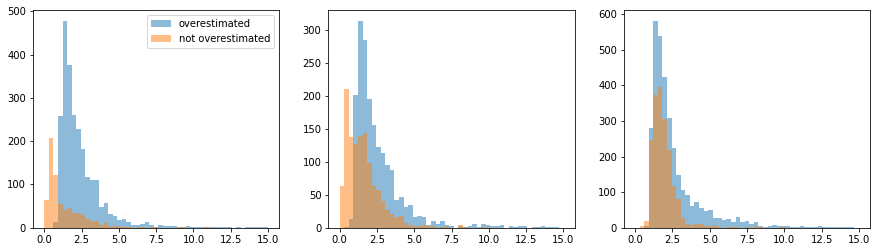

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist(dec_width[(charge_diff>-0.2) & (plane==0)]/sim_width[(charge_diff>-0.2) & (plane==0)],bins=np.linspace(0,15,50),label="overestimated",    alpha=0.5)
axes[0].hist(dec_width[(charge_diff<-0.2) & (plane==0)]/sim_width[(charge_diff<-0.2) & (plane==0)],bins=np.linspace(0,15,50),label="not overestimated",alpha=0.5)
axes[0].legend()

axes[1].hist(dec_width[(charge_diff>-0.1) & (plane==1)]/sim_width[(charge_diff>-0.1) & (plane==1)],bins=np.linspace(0,15,50),label="overestimated",    alpha=0.5)
axes[1].hist(dec_width[(charge_diff<-0.1) & (plane==1)]/sim_width[(charge_diff<-0.1) & (plane==1)],bins=np.linspace(0,15,50),label="not overestimated",alpha=0.5)
axes[0].legend()

axes[2].hist(dec_width[(charge_diff>0) & (plane==2)]/sim_width[(charge_diff>0) & (plane==2)],bins=np.linspace(0,15,50),label="overestimated",    alpha=0.5)
axes[2].hist(dec_width[(charge_diff<0) & (plane==2)]/sim_width[(charge_diff<0) & (plane==2)],bins=np.linspace(0,15,50),label="not overestimated",alpha=0.5)
axes[0].legend()

plt.show()

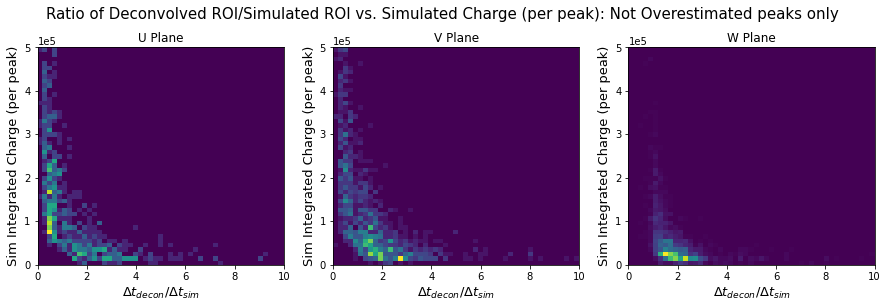

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,4))

axes[0].hist2d(dec_width[(charge_diff<-0.2) & (plane==0)]/sim_width[(charge_diff<-0.2) & (plane==0)],
               sim_charge[(charge_diff<-0.2) & (plane==0)],
               bins=[np.linspace(0,10,50),np.linspace(0,5e5,50)],label="not overestimated")


axes[1].hist2d(dec_width[(charge_diff<-0.1) & (plane==1)]/sim_width[(charge_diff<-0.1) & (plane==1)],
               sim_charge[(charge_diff<-0.1) & (plane==1)],
               bins=[np.linspace(0,10,50),np.linspace(0,5e5,50)],label="not overestimated")

axes[2].hist2d(dec_width[(charge_diff<0) & (plane==2)]/sim_width[(charge_diff<0) & (plane==2)],
               sim_charge[(charge_diff<0) & (plane==2)],
               bins=[np.linspace(0,10,50),np.linspace(0,5e5,50)],label="not overestimated")

# set y label to scientific notation
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.suptitle("Ratio of Deconvolved ROI/Simulated ROI vs. Simulated Charge (per peak): Not Overestimated peaks only",fontsize=15, y=1.02)
axes[0].set_xlabel("$\Delta t_{decon} / \Delta t_{sim}$",fontsize=13)
axes[1].set_xlabel("$\Delta t_{decon} / \Delta t_{sim}$",fontsize=13)
axes[2].set_xlabel("$\Delta t_{decon} / \Delta t_{sim}$",fontsize=13)

axes[0].set_ylabel("Sim Integrated Charge (per peak)",fontsize=13)
axes[1].set_ylabel("Sim Integrated Charge (per peak)",fontsize=13)
axes[2].set_ylabel("Sim Integrated Charge (per peak)",fontsize=13)

axes[0].set_title("U Plane",fontsize=12)
axes[1].set_title("V Plane",fontsize=12)
axes[2].set_title("W Plane",fontsize=12)

plt.show()

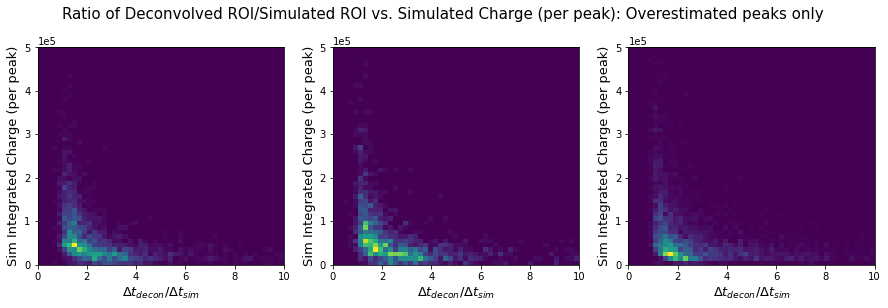

In [ ]:

fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist2d(dec_width[(charge_diff>-0.2) & (plane==0)]/sim_width[(charge_diff>-0.2) & (plane==0)],
               sim_charge[(charge_diff>-0.2) & (plane==0)],
               bins=[np.linspace(0,10,50),np.linspace(0,5e5,50)],label="overestimated",   )

axes[1].hist2d(dec_width[(charge_diff>-0.1) & (plane==1)]/sim_width[(charge_diff>-0.1) & (plane==1)],
               sim_charge[(charge_diff>-0.1) & (plane==1)],
               bins=[np.linspace(0,10,50),np.linspace(0,5e5,50)],label="overestimated",   )

axes[2].hist2d(dec_width[(charge_diff>0) & (plane==2)]/sim_width[(charge_diff>0) & (plane==2)],
               sim_charge[(charge_diff>0) & (plane==2)],
               bins=[np.linspace(0,10,50),np.linspace(0,5e5,50)],label="overestimated",   )

# set y label to scientific notation
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.suptitle("Ratio of Deconvolved ROI/Simulated ROI vs. Simulated Charge (per peak): Overestimated peaks only",fontsize=15, y=1.02)
axes[0].set_xlabel("$\Delta t_{decon} / \Delta t_{sim}$",fontsize=13)
axes[1].set_xlabel("$\Delta t_{decon} / \Delta t_{sim}$",fontsize=13)
axes[2].set_xlabel("$\Delta t_{decon} / \Delta t_{sim}$",fontsize=13)

axes[0].set_ylabel("Sim Integrated Charge (per peak)",fontsize=13)
axes[1].set_ylabel("Sim Integrated Charge (per peak)",fontsize=13)
axes[2].set_ylabel("Sim Integrated Charge (per peak)",fontsize=13)


axes[0].set_title("U Plane",fontsize=12)
axes[1].set_title("V Plane",fontsize=12)
axes[2].set_title("W Plane",fontsize=12)

plt.show()